In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True)
data = cifar_trainset.data / 255 # data is numpy array

mean = data.mean(axis = (0,1,2))
std = data.std(axis = (0,1,2))
print(f"Mean : {mean}   STD: {std}")

Files already downloaded and verified
Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))])

test_transforms = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))])

In [ ]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 128
shuffle = True

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=shuffle, pin_memory=True)

In [ ]:
images, labels = next(iter(train_dataloader))

In [ ]:
images.shape

torch.Size([128, 3, 32, 32])

In [ ]:
labels[0]

tensor(9)

In [ ]:
cifar_trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Text(0.5, 1.0, 'truck')

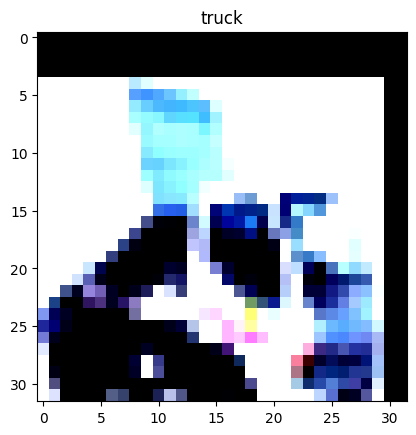

In [ ]:
plt.imshow(images[0].permute(1, 2, 0))
plt.title(cifar_trainset.classes[labels[0].item()])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, bias=False), # 32 > 32 | 1 > 3
            nn.ReLU(),
            nn.GroupNorm(1, 16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=False), # 32 > 32 | 3 > 5
            nn.ReLU(),
            nn.GroupNorm(1, 32)
        )

        # Transition Layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, bias=False), # 32 > 32 | 5 > 5
            nn.MaxPool2d(kernel_size=2) # 32 > 16 | 5 > 6
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False), # 16 > 16 | 6 > 10
            nn.ReLU(),
            nn.GroupNorm(1, 16)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False), # 16 > 16 | 10 > 14
            nn.ReLU(),
            nn.GroupNorm(1, 16)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=False), # 16 > 16 | 14 > 18
            nn.ReLU(),
            nn.GroupNorm(1, 32)
        )

        # Transition Layer
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, bias=False), # 16 > 16 | 18 > 18
            nn.MaxPool2d(kernel_size=2) # 16 > 8 | 18 > 20
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False), # 8 > 8 | 20 > 28
            nn.ReLU(),
            nn.GroupNorm(1, 16)
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False), # 8 > 8 | 28 > 36
            nn.ReLU(),
            nn.GroupNorm(1, 16)
        )
        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=False), # 8 > 8 | 36 > 44
            nn.ReLU(),
            nn.GroupNorm(1, 32)
        )

        self.gap = nn.AdaptiveAvgPool2d(output_size=1) # 8 >> 1 || GAP
        self.conv11 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1, bias=False) # 1 > 1


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.gap(x)
        x = self.conv11(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=1)


In [ ]:
model1 = Model1().to(device)
summary(model1, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,608
              ReLU-5           [-1, 32, 32, 32]               0
         GroupNorm-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 16, 32, 32]             512
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 16, 16, 16]           2,304
             ReLU-10           [-1, 16, 16, 16]               0
        GroupNorm-11           [-1, 16, 16, 16]              32
           Conv2d-12           [-1, 16, 16, 16]           2,304
             ReLU-13           [-1, 16, 16, 16]               0
        GroupNorm-14           [-1, 16,

In [ ]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=0, bias=False), # 32 > 30 | 1 > 3
            nn.ReLU(),
            nn.LayerNorm([8, 30, 30])
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=0, bias=False), # 30 > 28 | 3 > 5
            nn.ReLU(),
            nn.LayerNorm([8, 28, 28])
        )

        # Transition Layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=4, kernel_size=1, bias=False), # 28 > 28 | 5 > 5
            nn.MaxPool2d(kernel_size=2) # 28 > 14 | 5 > 6
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1, bias=False), # 14 > 14 | 6 > 10
            nn.ReLU(),
            nn.LayerNorm([8, 14, 14])
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False), # 14 > 14 | 10 > 14
            nn.ReLU(),
            nn.LayerNorm([8, 14, 14])
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0, bias=False), # 14 > 12 | 14 > 18
            nn.ReLU(),
            nn.LayerNorm([16, 12, 12])
        )

        # Transition Layer
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1, bias=False), # 12 > 12 | 18 > 18
            nn.MaxPool2d(kernel_size=2) # 12 > 6 | 18 > 20
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False), # 6 > 6 | 20 > 28
            nn.ReLU(),
            nn.LayerNorm([8, 6, 6])
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1, bias=False), # 6 > 6 | 28 > 36
            nn.ReLU(),
            nn.LayerNorm([8, 6, 6])
        )
        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, bias=False), # 6 > 6 | 36 > 44
            nn.ReLU(),
            nn.LayerNorm([16, 6, 6])
        )

        self.gap = nn.AdaptiveAvgPool2d(output_size=1) # 6 >> 1 || GAP
        self.conv11 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1, bias=False) # 1 > 1
        self.dp = nn.Dropout(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dp(x)
        x = self.conv2(x)
        x = self.dp(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.dp(x)
        x = self.conv5(x)
        x = self.dp(x)
        x = self.conv6(x)
        x = self.dp(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.dp(x)
        x = self.conv9(x)
        x = self.dp(x)
        x = self.conv10(x)
        x = self.gap(x)
        x = self.conv11(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=1)


In [ ]:
model2 = Model2().to(device)
summary(model2, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             216
              ReLU-2            [-1, 8, 30, 30]               0
         LayerNorm-3            [-1, 8, 30, 30]          14,400
           Dropout-4            [-1, 8, 30, 30]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
         LayerNorm-7            [-1, 8, 28, 28]          12,544
           Dropout-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 4, 28, 28]              32
        MaxPool2d-10            [-1, 4, 14, 14]               0
           Conv2d-11            [-1, 8, 14, 14]             288
             ReLU-12            [-1, 8, 14, 14]               0
        LayerNorm-13            [-1, 8, 14, 14]           3,136
          Dropout-14            [-1, 8,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.05)

for epoch in range(20):
    print("epoch: ", epoch)
    train(model1, device, train_dataloader, optimizer, epoch)
    test(model1, device, test_dataloader)
    # scheduler.step()


epoch:  0


Loss=0.8012441396713257 Batch_id=390 Accuracy=80.68: 100%|██████████| 391/391 [00:27<00:00, 14.01it/s]



Test set: Average loss: 0.7099, Accuracy: 7527/10000 (75.27%)

epoch:  1


Loss=0.669472873210907 Batch_id=390 Accuracy=80.80: 100%|██████████| 391/391 [00:28<00:00, 13.75it/s]



Test set: Average loss: 0.7057, Accuracy: 7567/10000 (75.67%)

epoch:  2


Loss=0.4308125972747803 Batch_id=390 Accuracy=81.16: 100%|██████████| 391/391 [00:26<00:00, 14.91it/s]



Test set: Average loss: 0.7229, Accuracy: 7510/10000 (75.10%)

epoch:  3


Loss=0.5890579223632812 Batch_id=390 Accuracy=81.41: 100%|██████████| 391/391 [00:26<00:00, 15.01it/s]



Test set: Average loss: 0.7011, Accuracy: 7581/10000 (75.81%)

epoch:  4


Loss=0.3752428889274597 Batch_id=390 Accuracy=81.97: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s]



Test set: Average loss: 0.7074, Accuracy: 7600/10000 (76.00%)

epoch:  5


Loss=0.5517669916152954 Batch_id=390 Accuracy=82.32: 100%|██████████| 391/391 [00:26<00:00, 15.04it/s]



Test set: Average loss: 0.7336, Accuracy: 7532/10000 (75.32%)

epoch:  6


Loss=0.36508938670158386 Batch_id=390 Accuracy=82.48: 100%|██████████| 391/391 [00:25<00:00, 15.15it/s]



Test set: Average loss: 0.7336, Accuracy: 7497/10000 (74.97%)

epoch:  7


Loss=0.40332213044166565 Batch_id=390 Accuracy=82.60: 100%|██████████| 391/391 [00:26<00:00, 14.91it/s]



Test set: Average loss: 0.7039, Accuracy: 7627/10000 (76.27%)

epoch:  8


Loss=0.7224531173706055 Batch_id=390 Accuracy=83.06: 100%|██████████| 391/391 [00:25<00:00, 15.11it/s]



Test set: Average loss: 0.7039, Accuracy: 7612/10000 (76.12%)

epoch:  9


Loss=0.603760838508606 Batch_id=390 Accuracy=83.10: 100%|██████████| 391/391 [00:26<00:00, 14.75it/s]



Test set: Average loss: 0.7197, Accuracy: 7585/10000 (75.85%)

epoch:  10


Loss=0.5529518723487854 Batch_id=390 Accuracy=83.43: 100%|██████████| 391/391 [00:26<00:00, 14.62it/s]



Test set: Average loss: 0.7725, Accuracy: 7456/10000 (74.56%)

epoch:  11


Loss=0.5385376811027527 Batch_id=390 Accuracy=83.64: 100%|██████████| 391/391 [00:26<00:00, 14.94it/s]



Test set: Average loss: 0.7275, Accuracy: 7546/10000 (75.46%)

epoch:  12


Loss=0.4422895908355713 Batch_id=390 Accuracy=83.97: 100%|██████████| 391/391 [00:25<00:00, 15.04it/s]



Test set: Average loss: 0.7399, Accuracy: 7574/10000 (75.74%)

epoch:  13


Loss=0.5536589622497559 Batch_id=390 Accuracy=83.90: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]



Test set: Average loss: 0.7205, Accuracy: 7632/10000 (76.32%)

epoch:  14


Loss=0.5175666213035583 Batch_id=390 Accuracy=84.34: 100%|██████████| 391/391 [00:21<00:00, 17.92it/s]



Test set: Average loss: 0.7034, Accuracy: 7625/10000 (76.25%)

epoch:  15


Loss=0.4422679543495178 Batch_id=390 Accuracy=84.45: 100%|██████████| 391/391 [00:21<00:00, 18.36it/s]



Test set: Average loss: 0.7286, Accuracy: 7586/10000 (75.86%)

epoch:  16


Loss=0.7610480189323425 Batch_id=390 Accuracy=84.43: 100%|██████████| 391/391 [00:22<00:00, 17.65it/s]



Test set: Average loss: 0.7333, Accuracy: 7588/10000 (75.88%)

epoch:  17


Loss=0.45770058035850525 Batch_id=390 Accuracy=84.73: 100%|██████████| 391/391 [00:20<00:00, 18.63it/s]



Test set: Average loss: 0.7218, Accuracy: 7587/10000 (75.87%)

epoch:  18


Loss=0.37104955315589905 Batch_id=390 Accuracy=85.15: 100%|██████████| 391/391 [00:21<00:00, 18.45it/s]



Test set: Average loss: 0.7357, Accuracy: 7587/10000 (75.87%)

epoch:  19


Loss=0.36042624711990356 Batch_id=390 Accuracy=85.07: 100%|██████████| 391/391 [00:21<00:00, 18.13it/s]



Test set: Average loss: 0.7237, Accuracy: 7602/10000 (76.02%)



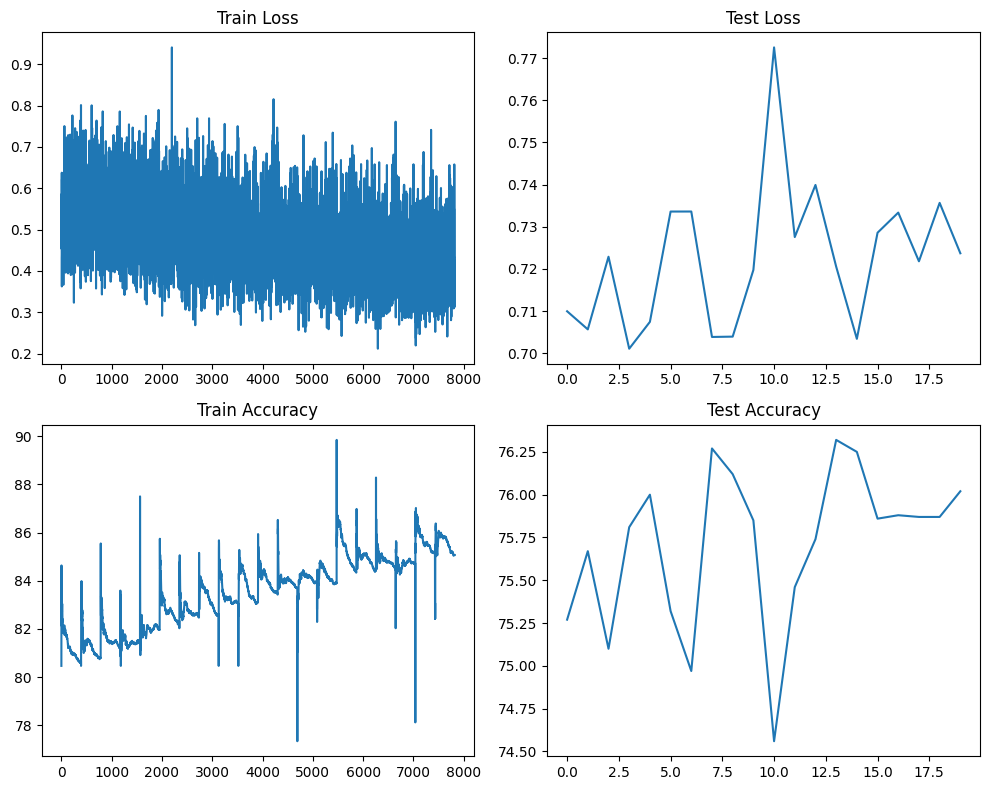

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot( [t.item() for t in train_losses])
axs[0, 0].set_title('Train Loss')
axs[0, 1].plot(test_losses)
axs[0, 1].set_title('Test Loss')
axs[1, 0].plot(train_acc)
axs[1, 0].set_title('Train Accuracy')
axs[1, 1].plot(test_acc)
axs[1, 1].set_title('Test Accuracy')

fig.tight_layout()

In [ ]:
def predict(model, device, test_loader):
    model.eval()
    wrong_labels = []
    image_list = []
    pred_list = []
    label_list = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data)
            preds = output.argmax(dim=1, keepdim=True).cpu()  # get the index of the max log-probability

            wrong_indices = torch.argwhere(preds != target).flatten()
            pred_list += preds[wrong_indices].tolist()
            image_list += [img for img in images[wrong_indices].cpu()]
            label_list += labels[wrong_indices].tolist()

            if len(label_list) > 10:
                break


    pred_list = pred_list[:10]
    label_list = label_list[:10]
    image_list = image_list[:10]

    fig, axs = plt.subplots(5, 2, figsize=(16, 10))
    for i in range(5):
        for j in range(2):
            img = image_list.pop()
            img = img / 2 + 0.5     # unnormalize
            img = img.numpy()
            axs[i,j].imshow(np.transpose(img, (1, 2, 0)))

            axs[i,j].set_title(f"Label: {cifar_trainset.classes[label_list.pop()]} | Pred: {cifar_trainset.classes[pred_list.pop()[0]]}")
    fig.tight_layout()

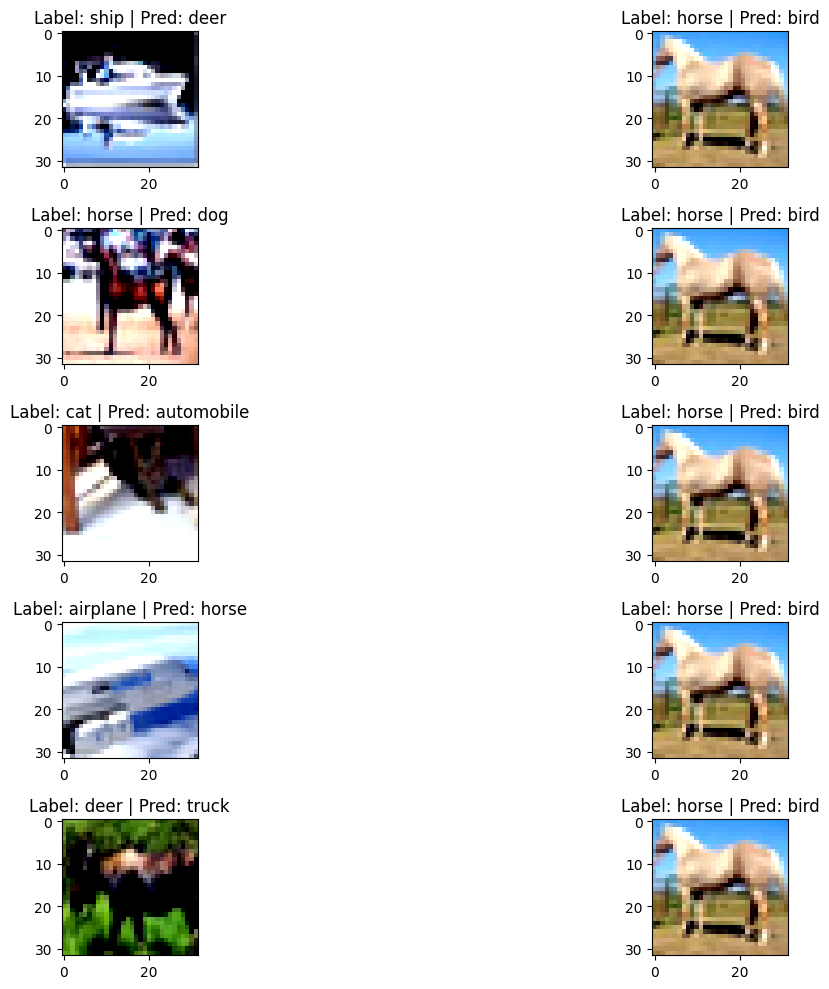

In [ ]:
predict(model1, device, test_dataloader)

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
optimizer = optim.SGD(model2.parameters(), lr=0.08, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.05)

for epoch in range(20):
    print("epoch: ", epoch)
    train(model2, device, train_dataloader, optimizer, epoch)
    test(model2, device, test_dataloader)
    # scheduler.step()

epoch:  0


Loss=1.5127159357070923 Batch_id=390 Accuracy=48.91: 100%|██████████| 391/391 [00:37<00:00, 10.40it/s]



Test set: Average loss: 1.3112, Accuracy: 5263/10000 (52.63%)

epoch:  1


Loss=1.3214633464813232 Batch_id=390 Accuracy=49.72: 100%|██████████| 391/391 [00:28<00:00, 13.87it/s]



Test set: Average loss: 1.2795, Accuracy: 5367/10000 (53.67%)

epoch:  2


Loss=1.2651822566986084 Batch_id=390 Accuracy=50.53: 100%|██████████| 391/391 [00:29<00:00, 13.34it/s]



Test set: Average loss: 1.2681, Accuracy: 5469/10000 (54.69%)

epoch:  3


Loss=1.2876551151275635 Batch_id=390 Accuracy=51.55: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]



Test set: Average loss: 1.2708, Accuracy: 5466/10000 (54.66%)

epoch:  4


Loss=1.1021440029144287 Batch_id=390 Accuracy=52.09: 100%|██████████| 391/391 [00:29<00:00, 13.34it/s]



Test set: Average loss: 1.2463, Accuracy: 5548/10000 (55.48%)

epoch:  5


Loss=1.4371343851089478 Batch_id=390 Accuracy=52.50: 100%|██████████| 391/391 [00:28<00:00, 13.74it/s]



Test set: Average loss: 1.2027, Accuracy: 5676/10000 (56.76%)

epoch:  6


Loss=1.3743231296539307 Batch_id=390 Accuracy=53.36: 100%|██████████| 391/391 [00:28<00:00, 13.50it/s]



Test set: Average loss: 1.2508, Accuracy: 5567/10000 (55.67%)

epoch:  7


Loss=1.5149773359298706 Batch_id=390 Accuracy=53.54: 100%|██████████| 391/391 [00:28<00:00, 13.77it/s]



Test set: Average loss: 1.1755, Accuracy: 5808/10000 (58.08%)

epoch:  8


Loss=1.1596866846084595 Batch_id=390 Accuracy=54.01: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]



Test set: Average loss: 1.1705, Accuracy: 5792/10000 (57.92%)

epoch:  9


Loss=1.3871411085128784 Batch_id=390 Accuracy=54.21: 100%|██████████| 391/391 [00:28<00:00, 13.77it/s]



Test set: Average loss: 1.1857, Accuracy: 5738/10000 (57.38%)

epoch:  10


Loss=1.1569647789001465 Batch_id=390 Accuracy=54.63: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s]



Test set: Average loss: 1.1745, Accuracy: 5788/10000 (57.88%)

epoch:  11


Loss=1.3644899129867554 Batch_id=390 Accuracy=54.83: 100%|██████████| 391/391 [00:29<00:00, 13.48it/s]



Test set: Average loss: 1.1482, Accuracy: 5921/10000 (59.21%)

epoch:  12


Loss=1.3158032894134521 Batch_id=390 Accuracy=55.16: 100%|██████████| 391/391 [00:29<00:00, 13.34it/s]



Test set: Average loss: 1.1837, Accuracy: 5829/10000 (58.29%)

epoch:  13


Loss=1.4895753860473633 Batch_id=390 Accuracy=55.81: 100%|██████████| 391/391 [00:29<00:00, 13.04it/s]



Test set: Average loss: 1.1322, Accuracy: 6001/10000 (60.01%)

epoch:  14


Loss=0.9510728120803833 Batch_id=390 Accuracy=55.71: 100%|██████████| 391/391 [00:29<00:00, 13.41it/s]



Test set: Average loss: 1.1393, Accuracy: 5971/10000 (59.71%)

epoch:  15


Loss=1.332503080368042 Batch_id=390 Accuracy=56.00: 100%|██████████| 391/391 [00:28<00:00, 13.56it/s]



Test set: Average loss: 1.1394, Accuracy: 5935/10000 (59.35%)

epoch:  16


Loss=1.4953540563583374 Batch_id=390 Accuracy=56.59: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]



Test set: Average loss: 1.1201, Accuracy: 6031/10000 (60.31%)

epoch:  17


Loss=1.0980271100997925 Batch_id=390 Accuracy=56.56: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s]



Test set: Average loss: 1.1538, Accuracy: 5895/10000 (58.95%)

epoch:  18


Loss=1.0292631387710571 Batch_id=390 Accuracy=56.89: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]



Test set: Average loss: 1.1026, Accuracy: 6082/10000 (60.82%)

epoch:  19


Loss=1.182851791381836 Batch_id=390 Accuracy=56.65: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]



Test set: Average loss: 1.0971, Accuracy: 6103/10000 (61.03%)



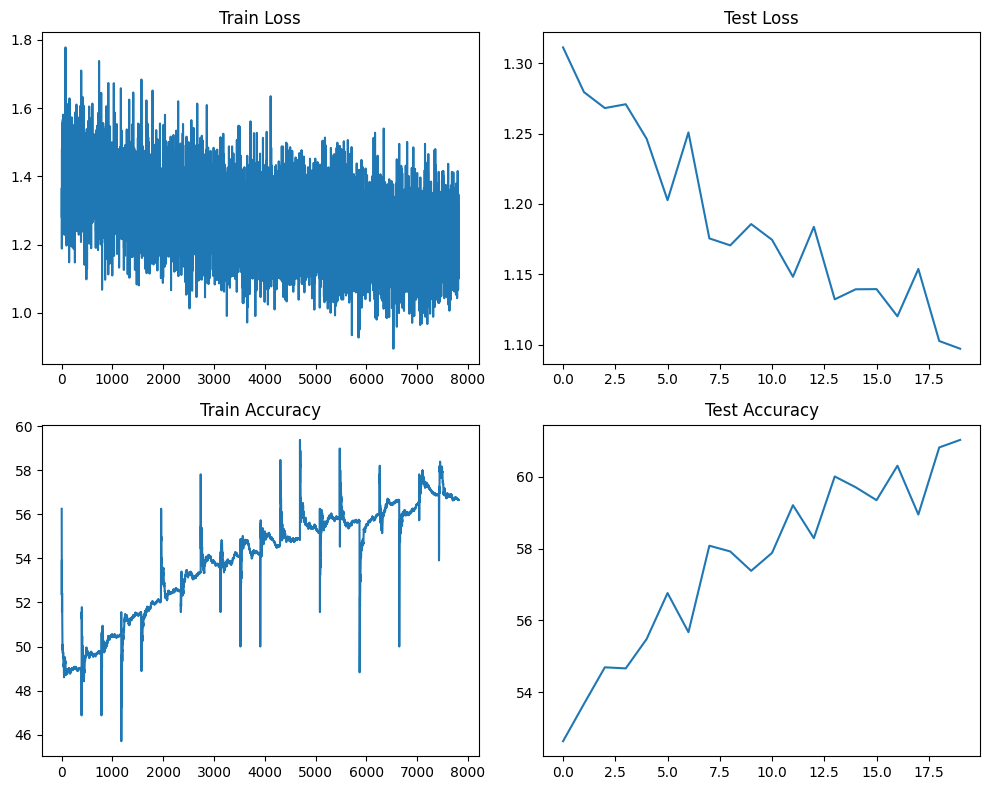

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot( [t.item() for t in train_losses])
axs[0, 0].set_title('Train Loss')
axs[0, 1].plot(test_losses)
axs[0, 1].set_title('Test Loss')
axs[1, 0].plot(train_acc)
axs[1, 0].set_title('Train Accuracy')
axs[1, 1].plot(test_acc)
axs[1, 1].set_title('Test Accuracy')

fig.tight_layout()

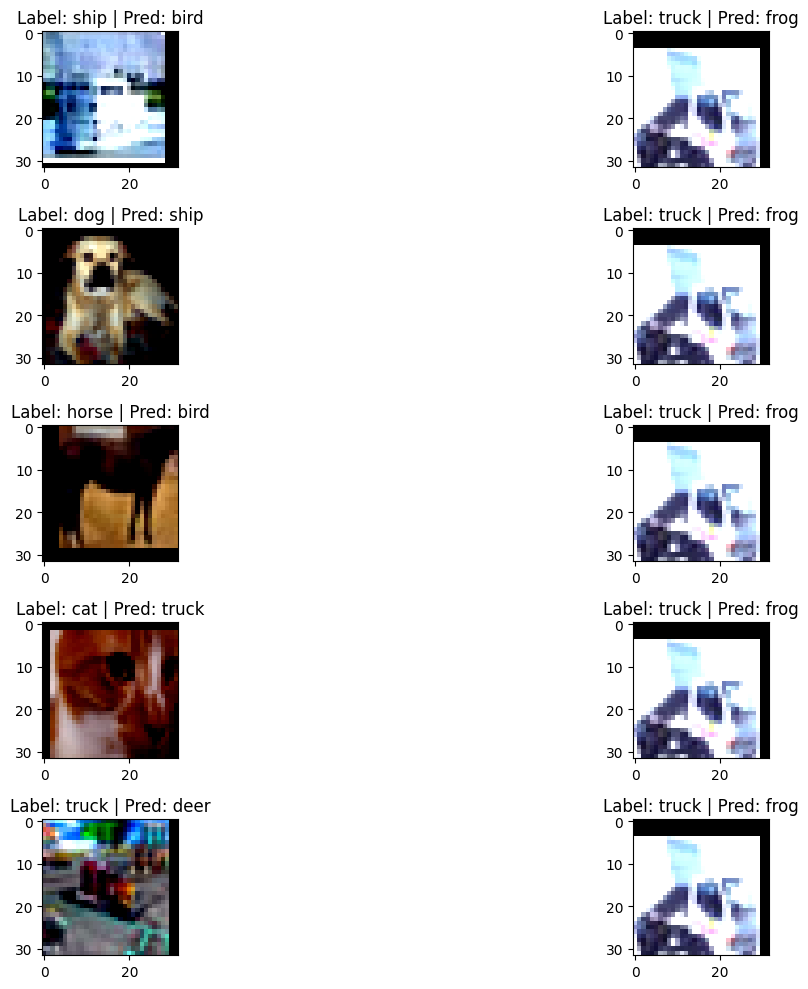

In [ ]:
predict(model2, device, test_dataloader)